# Paper Replication

This code replicates the paper ["Subsampling techniques and the Jackknife 
methodology in the estimation of the extremal index"](https://doi.org/10.1016/j.csda.2007.06.023) by 
M. Ivette Gomes, Andreia Hall, M. Cristina Miranda.

Coded by:
Pankhuri Saxena

Running time: approx 20 minutes (mainly due to figure 3)

In [1]:
# getting the library that has some of the functions needed for simulations
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import time
from numba import njit, prange
import pandas as pd

%matplotlib inline

In [2]:
# global variables

# number of samples
n = 1000

# number of replications
runs = 20

# number of replicates for each run
replicates = 10

# the original paper uses 5000 runs and 10 replicates
# here runs is reducess to 20 for faster running time

### Defining functions

In [3]:
def cdf_inv_fr(u, gamma):
    """
        Returns the CDF of Inverse of F distribution
        
        Inputs:
            u: random variable
            gamma: paramter for the distribution 
            
        Returns:
            value of CDF for u with parameter gamma
    """
    return ((pow(-np.log(u) , -gamma)))

In [4]:
def cdf_inv_H(u , gamma, beta):
    """
        Inverse of the function H, as defined in the paper
        
        Inputs:
            u: random variable
            gamma, beta: parameters
            
        Returns:
            inverse of function H
    """
    return (pow(-np.log(u)/(pow(beta , -1/gamma)-1) , -gamma) )

In [5]:
def armax(beta , gamma, n, random_state = 124):
    """
        Generates ARMAX process with given parameters
        ARMAX is defined as 
            X_i = beta * max(X_i-1, Z_i) 
            where Z_i is random variabel from U(0,1)
        
        Inputs:
            beta, gamma: parameters
            n: sample size
            random_state: random_state for numpy 
            
        Returns:
            x: array of values following the given ARMAX process
    """
    # initial the array
    x = np.zeros(n)
    
    # fix the random state
    r = np.random.RandomState(random_state)
    
    # generate a random variable from a uniform distribution U(0,1)
    u = r.uniform(0,1,1)[0]
    
    # compute the function F
    x0 = cdf_inv_fr(u,gamma)
    
    # set the initial lag value
    xi_lag = x0
    x[0] = x0

    # variable to keep track of iterations
    t = 1
    
    # loop for computing ARMAX process
    for i in range(n-1):
        # setting a new random state to get different random variables
        r2 = np.random.RandomState(random_state + i)
        
        # generate a random variable from a uniform distribution U(0,1)
        u = r2.uniform(0,1,1)[0]
        
        # compute the value of inverse of function H
        zi = cdf_inv_H(u,gamma,beta)
        
        # calculate value at the given iteration
        xi = beta*max(xi_lag , zi)
        
        # save values for the next iteration
        xi_lag = xi
        x[t] = xi
        t = t + 1
 
    return x

In [6]:
def theta_n_k(X, k_=1):
    """
        Computes the value of extremal extremal index
        using Equation 7 of the paper
        
        Inputs:
            X: distribution
            k_: k-th top order statistic (k = 1 is the maximum)
            
        Returns:
            computed value of theta in the simulation
    """
    # initialize values
    sum_ = 0
    k = int(k_)

    # compute the value of k-th order statistic
    X_k = np.partition(X, n-k-1)[n-k-1]

  
    # computing values satisfying equation 7
    for j in range(n-1):
        # k-th top order equals n-k low order
        if X[j] <= X_k and X[j+1] > X_k:
            sum_ += 1

    # for the trivial case
    if k == 0:
        return 1

    return sum_/k

In [7]:
def theta_GJ_k(X, k, delta):
    """
        Computing the value of extremal index using
        Generalized Jacknnife methodology
        Uses equation 16 of the paper
        
        X: distribution
        k: order statistic
        delta: tuning parameter, between 0 and 1 (exclusive)
        
        Returns 
            theta: value of extremal index (theta) by the given method
    
    """

    # compute the numerator and denominator for Equation 16 of the paper
    numerator = (delta*delta + 1) * theta_n_k(X, int(np.floor(delta*k)) + 1) - delta*(theta_n_k(X, int(np.floor(delta*delta*k)) + 1) + theta_n_k(X, k))
    denominator = (1 - delta)**2

    # for the trivial case
    if numerator < 0: 
        return 0

    #return the value of theta
    theta = numerator/denominator
    return theta

### Figure 1

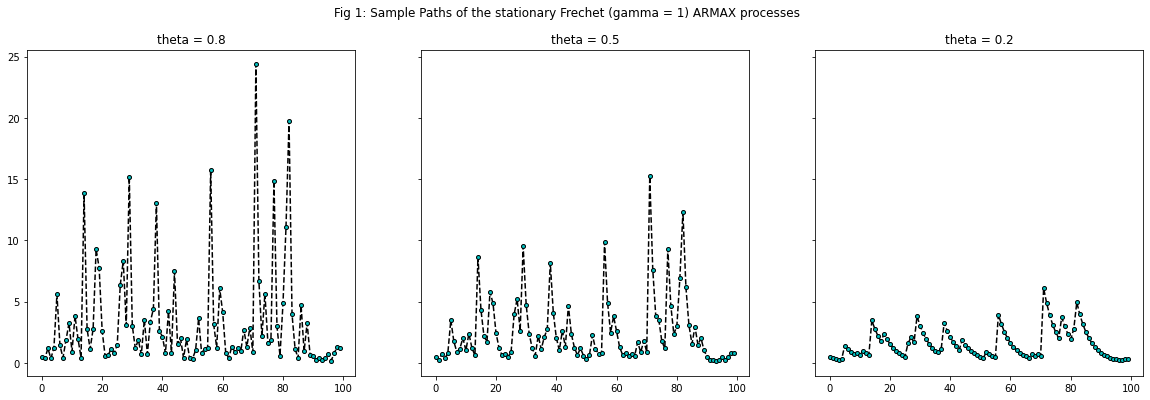

In [8]:
# recreates Fig 1 in the paper

# sample ARMAX processes
armx1 = armax(0.2 , 1 , 100)
armx2 = armax(0.5 , 1 , 100)
armx3 = armax(0.8 , 1 , 100)

# plotting the figure
fig, axs = plt.subplots(1, 3, sharey = True, figsize = (20,6))
fig.suptitle('Fig 1: Sample Paths of the stationary Frechet (gamma = 1) ARMAX processes')

# first panel
axs[0].plot(armx1, "--ko", ms = 4, mec = "k", mfc = "c")
axs[0].set_title('theta = 0.8')

#second panel
axs[1].plot(armx2, '--ko', ms = 4, mec = "k", mfc = "c")
axs[1].set_title('theta = 0.5')

# third panel
axs[2].plot(armx3, "--ko", ms = 4, mec = "k", mfc = "c")
axs[2].set_title("theta = 0.2")

# save the figure
plt.savefig("figures/figure 1.png")

### Figure 2

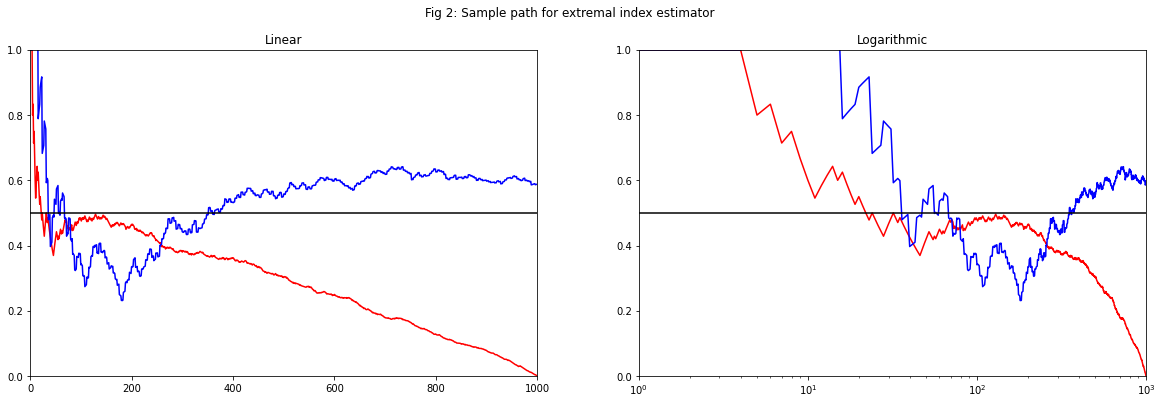

In [9]:
# Replicates figure 2 of the paper

# get a ARMAX sample
sample = np.array(armax(0.5, 1, n))

# define the range of order stats to compute
k_range = list(range(n))

# variable for drawing the straight line
straight_line = 0.5 * np.ones(n)

# initializing the two paths in the graph
path1 = np.zeros(n)
path2 = np.zeros(n)

# computing value of theta_n_k for two paths
# using the standard method and GJ method
for k in k_range:
    path1[k] = theta_n_k(sample, k)
    path2[k] = theta_GJ_k(sample, k, delta = 0.25)
    

# the figure 
fig, axs = plt.subplots(1, 2, figsize = (20,6))
fig.suptitle('Fig 2: Sample path for extremal index estimator')

# panel 1
axs[0].plot(k_range, path1, "r-")
axs[0].plot(k_range, path2, "b-")
axs[0].plot(k_range, straight_line, "k-")
axs[0].set_title('Linear')

# panel 2
axs[1].plot(k_range[1:], path1[1:], "r-")
axs[1].plot(k_range[1:], path2[1:], "b-")
axs[1].plot(k_range[1:], straight_line[1:], "k-")
axs[1].set_title('Logarithmic')
axs[1].set_xscale('log')

# setting the axis limits
axs[0].set_ylim([0,1])
axs[1].set_ylim([0,1])
axs[0].set_xlim([0,1000])
axs[1].set_xlim([1,1000])

plt.savefig("figures/figure 2.png")

### Modifying code for faster computations
using JIT compiler from numba

*The code in this section is same as the earlier code, but modified to be able to use jit using numba*

In [10]:
#@jit(nopython=True)
def cdf_inv_fr(u, gamma):
    """
        Returns the CDF of Inverse of F distribution
        
        Inputs:
            u: random variable
            gamma: paramter for the distribution 
            
        Returns:
            value of CDF for u with parameter gamma
    """
    return ((pow(-np.log(u) , -gamma)))

In [11]:
#@jit(nopython=True)
def cdf_inv_H(u , gamma, beta):
    """
        Inverse of the function H, as defined in the paper
        
        Inputs:
            u: random variable
            gamma, beta: parameters
            
        Returns:
            inverse of function H
    """
    return (pow(-np.log(u)/(pow(beta , -1/gamma)-1) , -gamma) )

In [12]:
#@jit(nopython=True)
def armax(beta , gamma, n, random_state = 124):
    """
        Generates ARMAX process with given parameters
        ARMAX is defined as 
            X_i = beta * max(X_i-1, Z_i) 
            where Z_i is random variabel from U(0,1)
        
        Inputs:
            beta, gamma: parameters
            n: sample size
            random_state: random_state for numpy 
            
        Returns:
            x: array of values following the given ARMAX process
    """
    # initial the array
    x = np.zeros(n)
    
    # fix the random state
    r = np.random.RandomState(random_state)
    
    # generate a random variable from a uniform distribution U(0,1)
    u = r.uniform(0,1,1)[0]
    
    # compute the function F
    x0 = cdf_inv_fr(u,gamma)
    
    # set the initial lag value
    xi_lag = x0
    x[0] = x0

    # variable to keep track of iterations
    t = 1
    
    # loop for computing ARMAX process
    for i in range(n-1):
        # setting a new random state to get different random variables
        r2 = np.random.RandomState(random_state + i)
        
        # generate a random variable from a uniform distribution U(0,1)
        u = r2.uniform(0,1,1)[0]
        
        # compute the value of inverse of function H
        zi = cdf_inv_H(u,gamma,beta)
        
        # calculate value at the given iteration
        xi = beta*max(xi_lag , zi)
        
        # save values for the next iteration
        xi_lag = xi
        x[t] = xi
        t = t + 1
 
    return x

In [13]:
#@jit(nopython=True)
def theta_n_k(X, n, k_=1):
    """
        Computes the value of extremal extremal index
        using Equation 7 of the paper
        
        Inputs:
            X: distribution
            k_: k-th top order statistic (k = 1 is the maximum)
            
        Returns:
            computed value of theta in the simulation
    """
    # initialize values
    sum_ = 0
    k = int(k_)

    # compute the value of k-th order statistic
    X_k = np.partition(X, n-k-1)[n-k-1]

  
    # computing values satisfying equation 7
    for j in range(n-1):
        # k-th top order equals n-k low order
        if X[j] <= X_k and X[j+1] > X_k:
            sum_ += 1

    # for the trivial case
    if k == 0:
        return 1

    return sum_/k

In [14]:
#@jit(nopython=True)
def theta_GJ_k(X, n, k, delta):
    """
        Computing the value of extremal index using
        Generalized Jacknnife methodology
        Uses equation 16 of the paper
        
        X: distribution
        k: order statistic
        delta: tuning parameter, between 0 and 1 (exclusive)
        
        Returns 
            theta: value of extremal index (theta) by the given method
    
    """

    # compute the numerator and denominator for Equation 16 of the paper
    numerator = (delta*delta + 1) * theta_n_k(X, n, int(np.floor(delta*k)) + 1) - delta*(theta_n_k(X, n, int(np.floor(delta*delta*k)) + 1) + theta_n_k(X, n, k))
    denominator = (1 - delta)**2

    # for the trivial case
    if numerator < 0: 
        return 0

    #return the value of theta
    theta = numerator/denominator
    return theta

*Some helper functions*

In [15]:
#@jit(nopython = True)
def np_apply_along_axis(func1d, axis, arr):
    """
        Applies a given function on the specified axis of a 2-D array
        
        Inputs:
            func1d: function defined in 1 dimension
            axis: 0 or 1 defining the axis number
            arr: numpy array
            
        Returns:
            result: array with the function applied
    """
    # ensure that the input is correct
    assert arr.ndim == 2
    assert axis in [0, 1]
    
    # define the function for axis 0
    if axis == 0:
        # initialize the array
        result = np.empty(arr.shape[1])
        
        # apply function on axis 0
        for i in range(len(result)):
              result[i] = func1d(arr[:, i])
                
    # define the function for axis 1
    else:
        # initialize the array
        result = np.empty(arr.shape[0])
        
        # apply function on axis 1
        for i in range(len(result)):
            result[i] = func1d(arr[i, :])
    return result

### Simulation functions
The following function simulate the process

In [16]:
#@jit(nopython=True)
def simulate_mean_mse(n, theta, runs = 15, replicates = 10):
    """
        Computes mean and MSE for the estimator obtained through simulations
        
        Inputs:
            n: sample size
            theta: theoretical extremal index
            runs: number of times simulation is done
            replicates: number of simulation to calculate mean and MSE for one run
            
        Returns:
            val_mean: Mean of the samples
            val_mse: MSE of the samples
        
    """
    
    # initialize the array
    all_values_mean = np.zeros((runs, n))
    all_values_mse = np.zeros((runs, n))

    # loop for the runs
    for run in range(runs):
        
        #initialize array to store values of the path
        a = np.zeros((replicates, n))
        
        for i in range(replicates): 
            #generate the path
            a[i] = armax(1-theta, 1, n)
      
  
        # variable to store values
        path = np.zeros((replicates, n))
        path2 = np.zeros((replicates, n))

        # range of order statistics
        k_range = list(range(n))

        for k in k_range:
            for j in range(replicates):
                # get value of theta and its deviation
                path[j][k] = theta_n_k(a[j], n, k)
                path2[j][k] = (path[j][k] - theta)**2

    
        # # calculate mean and MSE of the simulations in one run
        all_values_mean[run] = np_apply_along_axis(np.mean, 0, path)
        all_values_mse[run] = np_apply_along_axis(np.mean, 0, path2)
    
    # Calculate mean and MSE    
    val_mean= np_apply_along_axis(np.mean, 0, all_values_mean)
    val_mse = np_apply_along_axis(np.mean, 0, all_values_mse)

    return val_mean, val_mse

In [17]:
#@jit(nopython=True)
def simulate_mean_mse_GJ(n, theta, delta = 0.25, runs = 15, replicates = 10):
    """
        Computes mean and MSE for the GJ estimator 
        obtained through simulations
        
        Inputs:
            n: sample size
            theta: theoretical extremal index
            runs: number of times simulation is done
            replicates: number of simulation to calculate mean and MSE for one run
            
        Returns:
            val_mean: Mean of the samples
            val_mse: MSE of the samples
        
    """
    
    # initialize the array
    all_values_mean = np.zeros((runs, n))
    all_values_mse = np.zeros((runs, n))

    # loop for the runs
    for run in range(runs):
        
        #initialize array to store values of the path
        a = np.zeros((replicates, n))
        
        for i in range(replicates): 
            #generate the path
            a[i] = armax(1-theta, 1, n)
  
        # variable to store values
        path = np.zeros((replicates, n))
        path2 = np.zeros((replicates, n))

        # range of order statistics
        k_range = list(range(n))

        for k in k_range:
            for j in range(replicates):
                # get value of theta and its deviation
                path[j][k] = theta_GJ_k(a[j], n, k, delta)
                path2[j][k] = (path[j][k] - theta)**2

    
        # # calculate mean and MSE of the simulations in one run
        all_values_mean[run] = np_apply_along_axis(np.mean, 0, path)
        all_values_mse[run] = np_apply_along_axis(np.mean, 0, path2)
    
    # Calculate mean and MSE    
    val_mean= np_apply_along_axis(np.mean, 0, all_values_mean)
    val_mse = np_apply_along_axis(np.mean, 0, all_values_mse)

    return val_mean, val_mse

### Figure 3

CPU times: user 16min 53s, sys: 9.61 s, total: 17min 3s
Wall time: 18min 15s


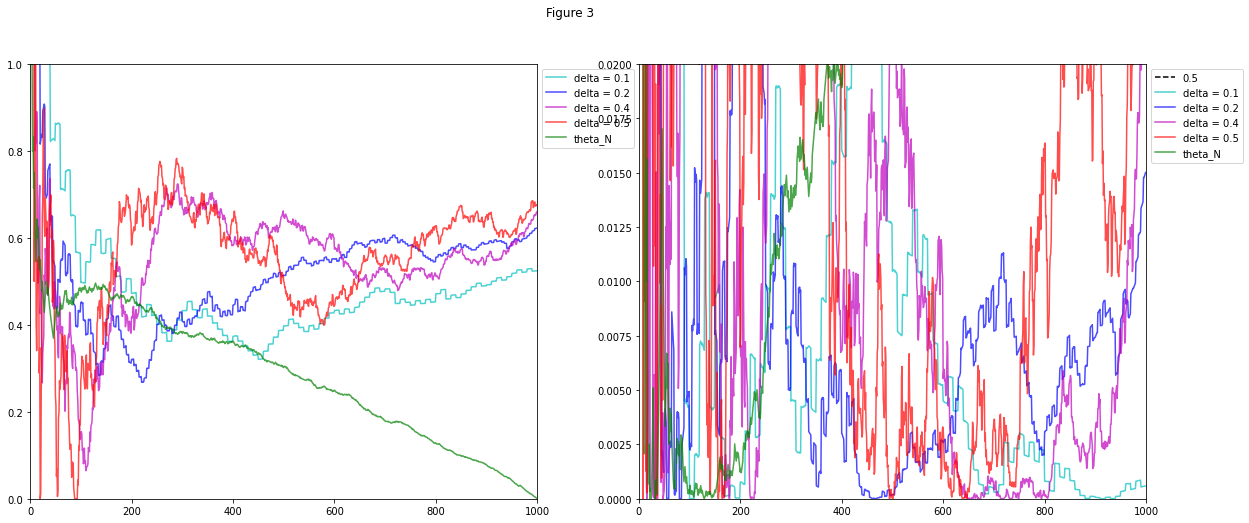

In [18]:
%%time

# Plotting Figure 3
theta = 0.5

# simulations
e_1000_5, mse_1000_5 = simulate_mean_mse(n, theta, runs = runs, replicates = replicates)
e_1000_5_1, mse_1000_5_1 = simulate_mean_mse_GJ(n, theta, delta = 0.1, runs = runs, replicates = replicates)
e_1000_5_2, mse_1000_5_2 = simulate_mean_mse_GJ(n, theta, delta = 0.2, runs = runs, replicates = replicates)
e_1000_5_4, mse_1000_5_4 = simulate_mean_mse_GJ(n, theta, delta = 0.4, runs = runs, replicates = replicates)
e_1000_5_5, mse_1000_5_5 = simulate_mean_mse_GJ(n, theta, delta = 0.5, runs = runs, replicates = replicates)

# for straight line
k_range = np.arange(n)
straight_line = theta*np.ones(n)

# plot
a = 0.7
fig, axs = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle("Figure 3")
axs[0].set_ylim([0, 1])
axs[0].set_xlim([0,1000])
axs[0].plot(k_range, e_1000_5_1, 'c-', label = 'delta = 0.1', alpha = a)
axs[0].plot(k_range, e_1000_5_2, 'b-', label = 'delta = 0.2', alpha = a)
axs[0].plot(k_range, e_1000_5_4, 'm-', label = 'delta = 0.4', alpha = a)
axs[0].plot(k_range, e_1000_5_5, 'r-', label = 'delta = 0.5', alpha = a)
axs[0].plot(k_range, e_1000_5, 'g-', label = 'theta_N', alpha = a)
axs[1].plot(k_range, straight_line, 'k--', label = '0.5')
axs[0].legend(bbox_to_anchor=(1.2, 1))

axs[1].set_ylim([0, 0.02])
axs[1].set_xlim([0,1000])
axs[1].plot(k_range, mse_1000_5_1, 'c-', label = 'delta = 0.1', alpha = a)
axs[1].plot(k_range, mse_1000_5_2, 'b-', label = 'delta = 0.2', alpha = a)
axs[1].plot(k_range, mse_1000_5_4, 'm-', label = 'delta = 0.4', alpha = a)
axs[1].plot(k_range, mse_1000_5_5, 'r-', label = 'delta = 0.5', alpha = a)
axs[1].plot(k_range, mse_1000_5, 'g-', label = 'theta_N', alpha = a)
axs[1].legend(bbox_to_anchor=(1.2, 1))

The graph on right above has random noise due to the small number of simulations run

Running for 5000 runs (as in paper) takes 3 hours and gives the following figure

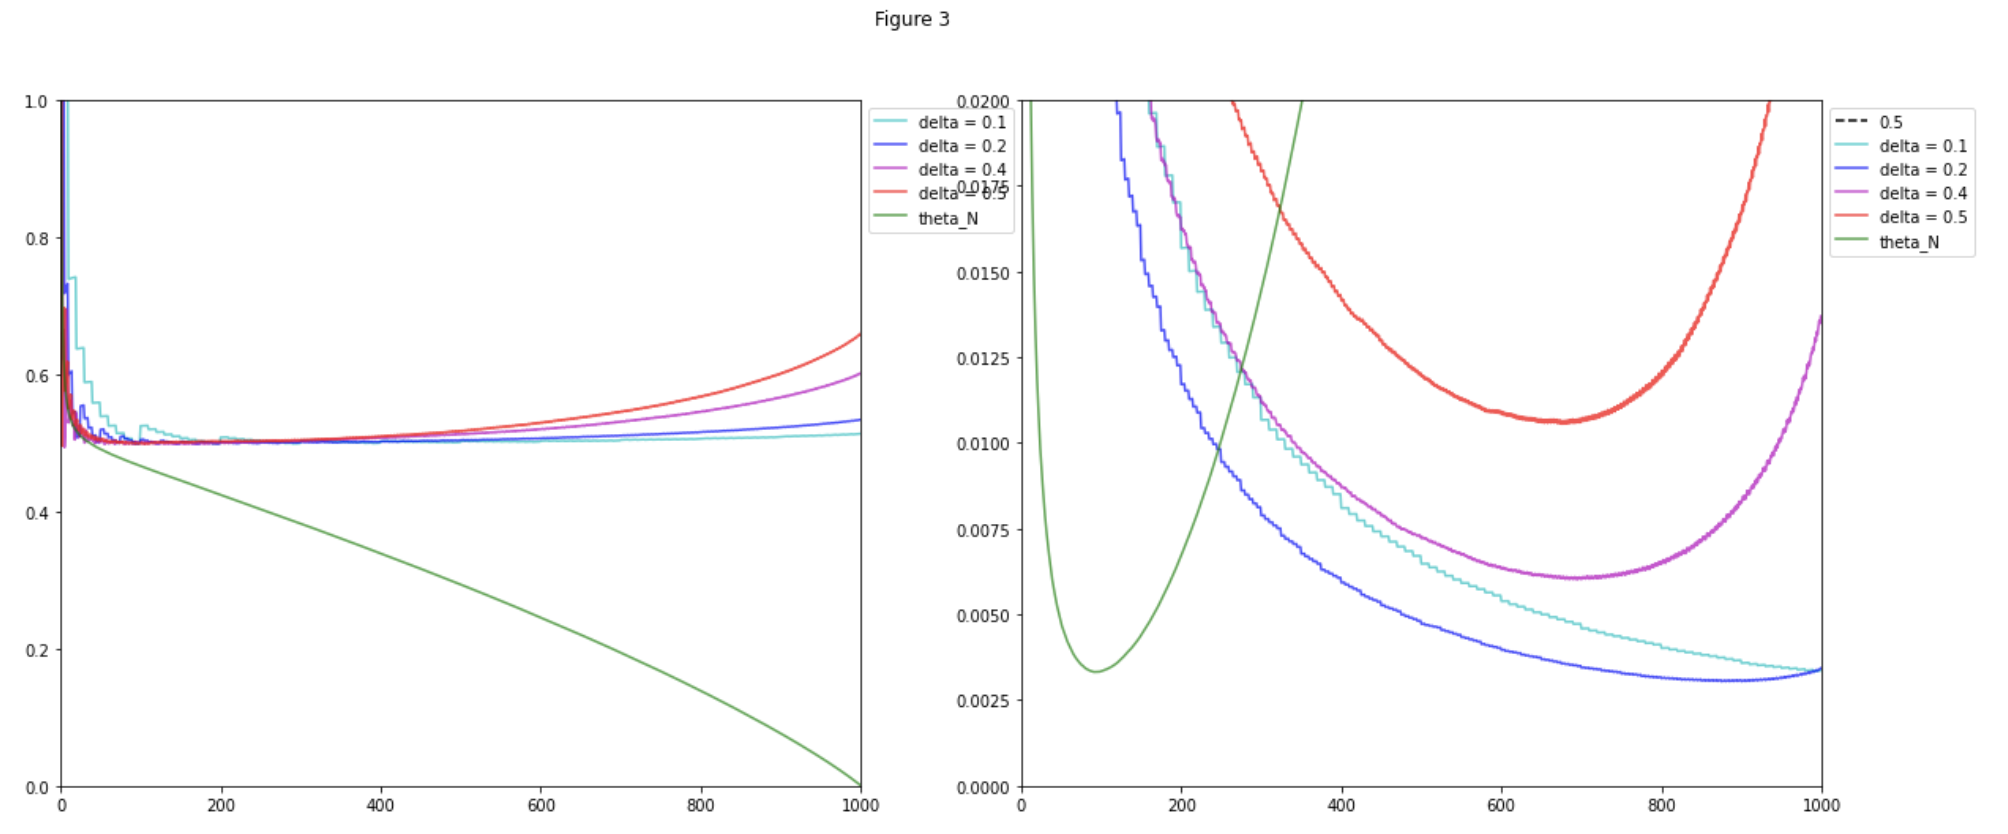

In [19]:
# save figure 3
plt.savefig("figures/figure 3.png")

<Figure size 432x288 with 0 Axes>

The rest of the figures in the paper can be generated by the same code by changing the value of theta. They are omitted in the code to preserve the running time to be less than half an hour

##### Figures 4-6 for reference

The rest of the figures produce on running the complete code with 500 runs look as follows:
(each figure takes approximately one hour to be generated with theta specified in the functions above specified)

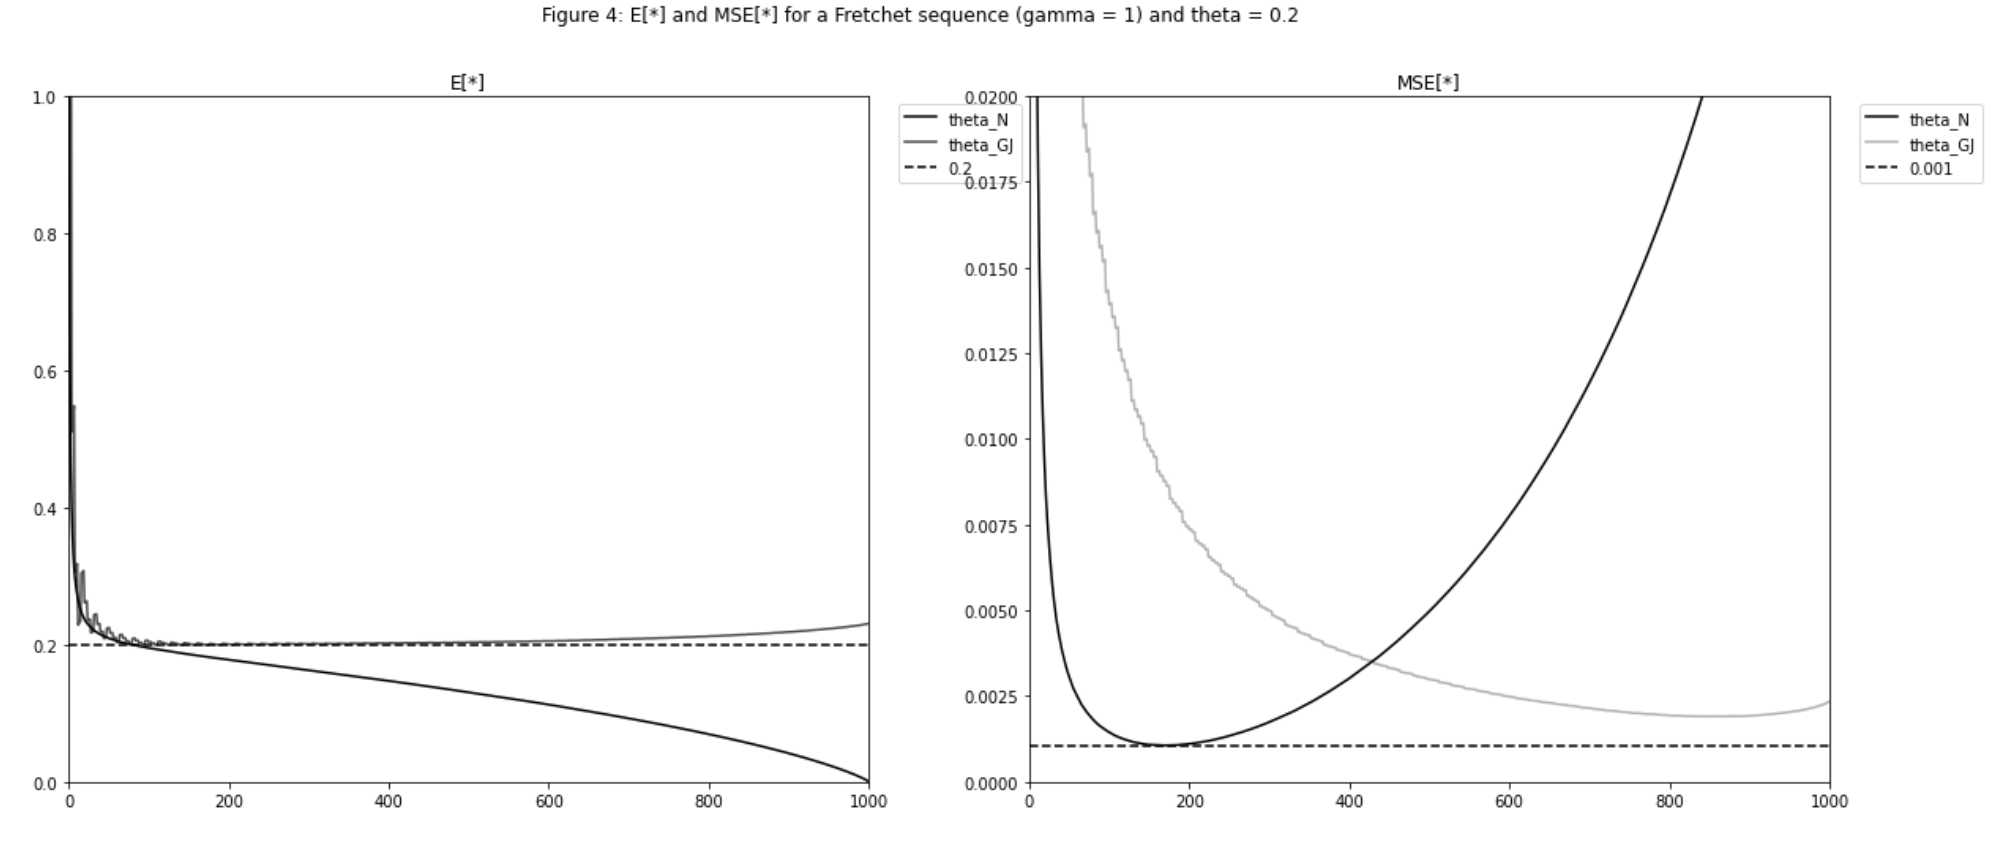

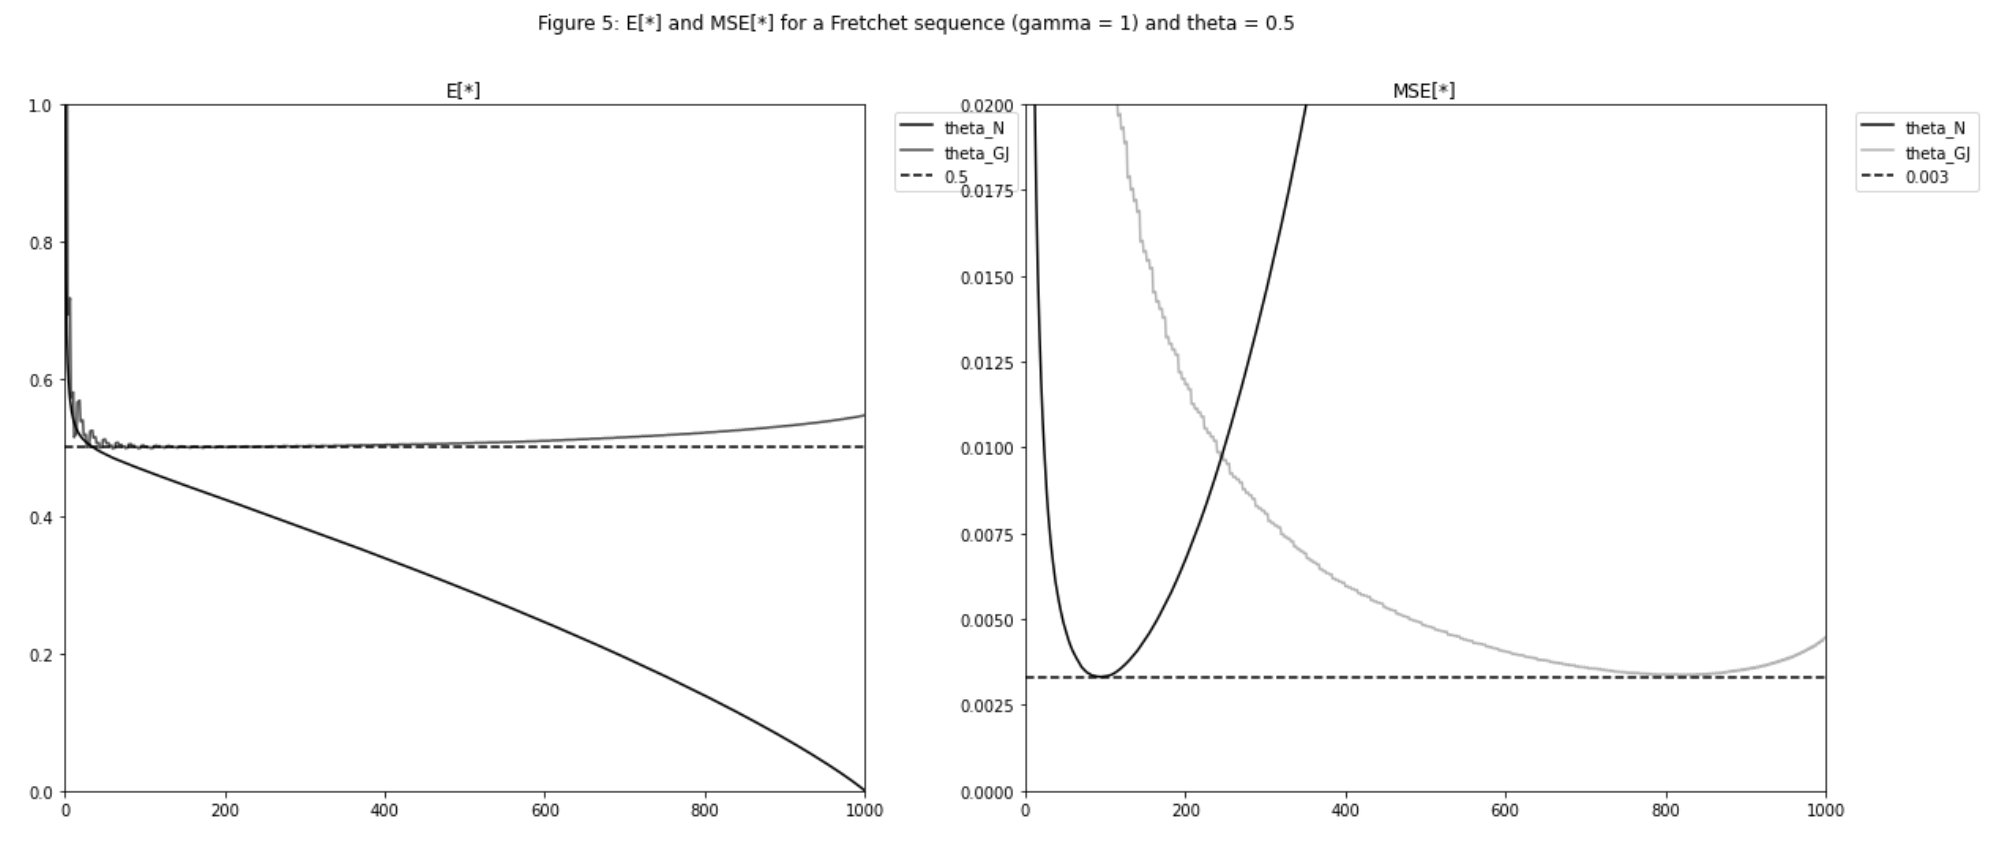

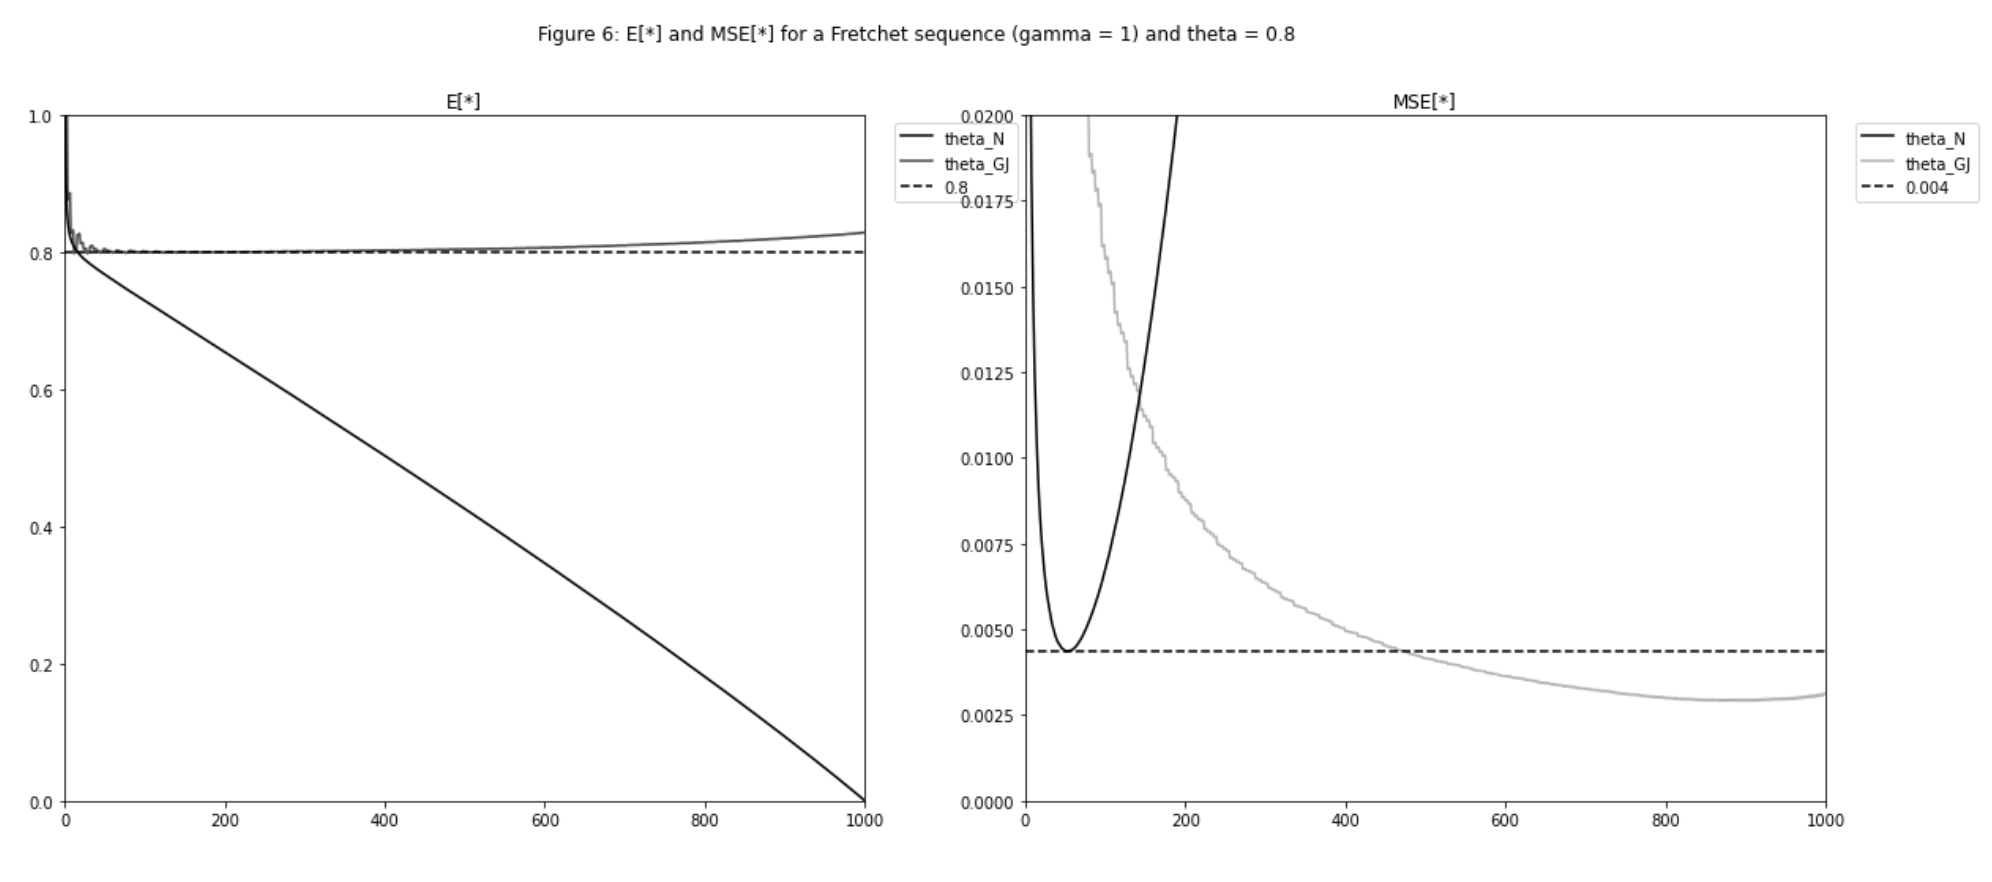